In [2]:
%load_ext autoreload
%autoreload 2
from modules import read_and_write
from modules import polyakov
from modules import utility
from modules import fourier_surface
from modules import surface_amplitudes as sf

import pandas as pd
import numpy as np
import os
import glob
indices = None

For reference with integration method the following surface tensions were computed

$z_1$: $\alpha_{o-o} / T^3(\beta=10.85) = 1.2316804724774406$

$z_2$: $\alpha_{o-o} / T^3(\beta=10.85) = 1.5433288477348852$

# Load data

In [20]:
from modules.globals import folder_names
choose_folder = 11
smooth_surfaces = {}
folder = folder_names[choose_folder-1]
files = glob.glob(os.path.join(folder, "surface_smooth_*"))
for file in files:
    file_name = file.split("/")[-1]
    smearing_level = file_name.split("_")[-1]
    volume, surface_smooth = read_and_write.read_surface_data(folder, file_name)
    smooth_surfaces[smearing_level] = surface_smooth
smooth_surfaces = dict(sorted(smooth_surfaces.items(), key=lambda item: int(item[0])))


In [14]:
np.unique([np.shape(instance) for instance in smooth_surfaces["10"]],return_counts=True)


(array([   3, 1935, 1936]), array([50000,     1, 49999]))

Smearing Level: 5
Smearing Level: 10
Smearing Level: 20
Smearing Level: 30
Smearing Level: 40
Smearing Level: 50


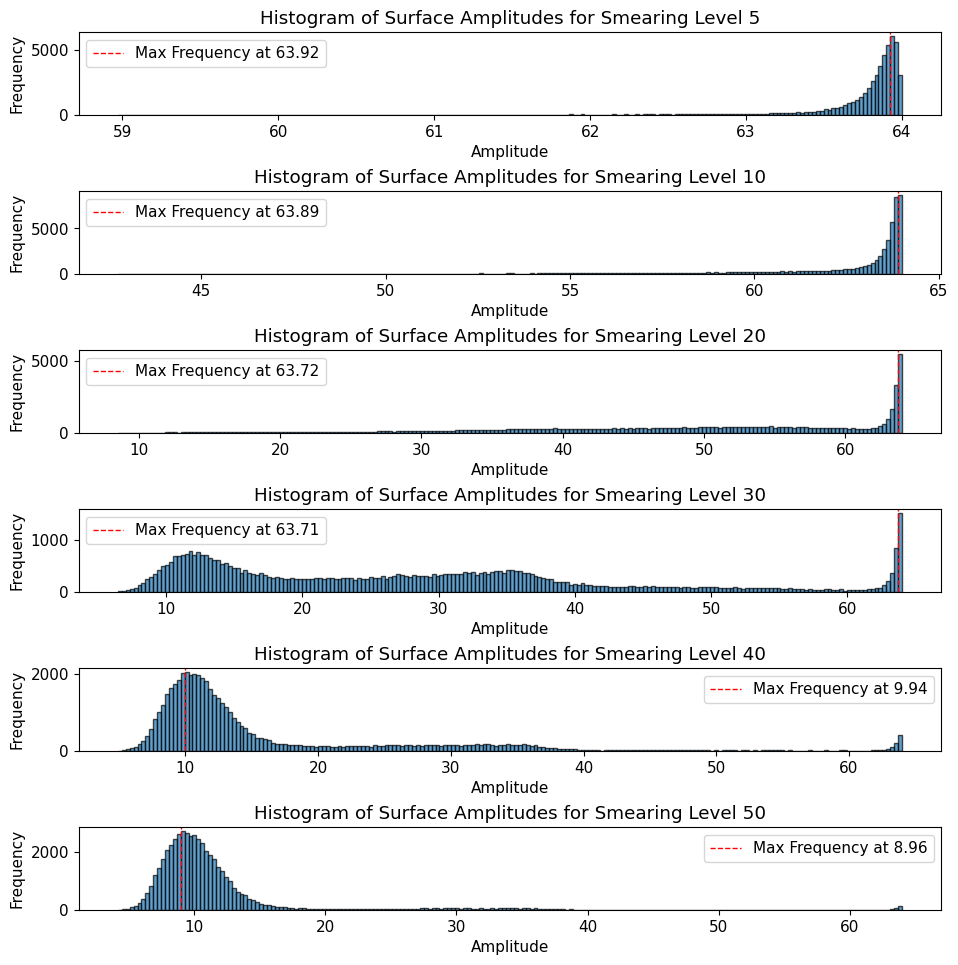

{'5': (63.804531172122424, 58.9724, 63.999700000000004), '10': (62.83896392461949, 42.74555, 63.9997), '20': (50.582185641391185, 8.523900000000001, 63.998799999999996), '30': (28.015290194510467, 6.4872, 63.99820000000001), '40': (15.572495922047082, 4.922699999999999, 63.9919), '50': (11.14660108979787, 4.1777000000000015, 63.994099999999996)}


In [21]:
indices = sf.surface_amplitudes(smooth_surfaces=smooth_surfaces,return_threshold=None,plot_histogram=True,thermalization=1000)

In [3]:
from modules.globals import folder_names

choose_folder = 11
fourier_profiles = {}
folder = folder_names[choose_folder-1]
files = glob.glob(os.path.join(folder, "fourier_profile_*"))
for file in files:
    file_name = file.split("/")[-1]
    smearing_level = file_name.split("_")[-1]
    volume, modes, fourier_profile = read_and_write.read_fourier_profile(folder,file_name=file_name)
    fourier_profiles[smearing_level] = fourier_profile
fourier_profiles = dict(sorted(fourier_profiles.items(), key=lambda item: int(item[0])))
utility.display_markdown_title(folder)

# $\text{SU}(4)$, $V$ = ['44', '44', '64', '6'], $\beta=$ 10.85, twist coeff $=$ 1

## Perform post processing

In [4]:
f_n_list = []
errors_list = []
for smearing_level, profile in fourier_profiles.items():
    if indices is not None:
        sample_size = len(profile)
        indices_set = indices[smearing_level]
        profile = np.delete(profile, list(indices_set), axis=0)
        print(f"Dropped {sample_size-len(profile)} samples")
    f_n, errors = utility.compute_with_aa_jackknife_fourier(profile, 10, thermalization=10000)
    f_n_list.append(f_n)
    errors_list.append(errors)



## Plot Fourier modes for different smearing steps

|   smearing | Linear fit ($\sigma / T^3$)   |
|-----------:|:------------------------------|
|          5 | 1.536 $\pm$ 0.222             |
|         10 | 1.142 $\pm$ 0.1036            |
|         20 | 1.098 $\pm$ 0.01854           |
|         30 | 1.151 $\pm$ 0.01104           |
|         40 | 1.206 $\pm$ 0.02504           |
|         50 | 1.261 $\pm$ 0.03514           |

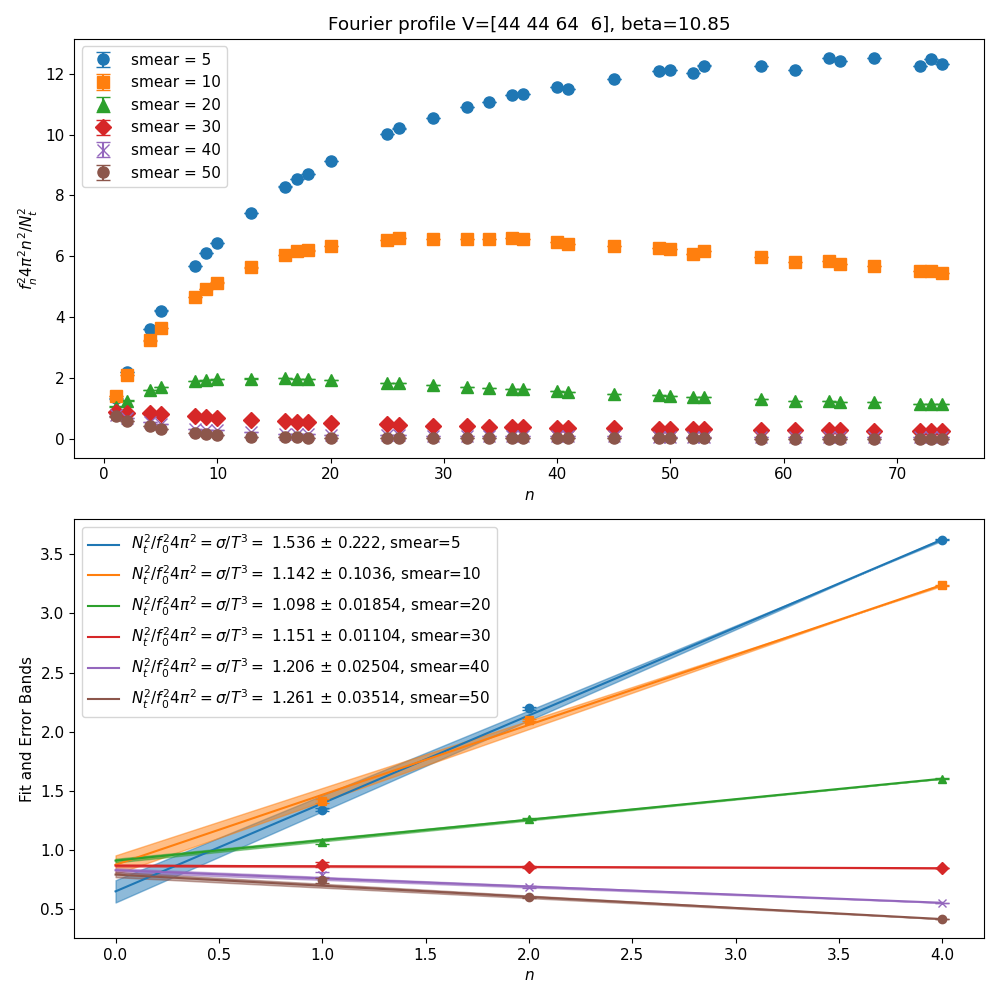

In [5]:
%matplotlib widget
smearing_levels = list(fourier_profiles.keys())
show_plot = True
data = {
    "smearing": smearing_levels,
    "linear": [
        fourier_surface.compute_fourier_profile(
            modes, f_n, volume, errors=error, beta=10.85, fit_range=3, smearing=smear, show_plot=show_plot
        ) for f_n, error, smear in zip( f_n_list, errors_list, smearing_levels)
    ]
    # "exponential": [
    #     fourier_surface.compute_fourier_profile_exponential_fit(
    #         n_2, f_n, volume, errors=error, beta=10.85, smearing=smear, show_plot=show_plot
    #     ) for n_2, f_n, error, smear in zip(n_2_list, f_n_list, errors_list, smearing_levels)
    # ]
}
df = pd.DataFrame(data)
utility.print_df_as_markdown_fourier_modes(df)
fourier_surface.global_fig = None